## Capstone 2 Project: Prediction of WAR in MLB players

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, RFE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import sklearn


# disable warnings
import warnings
warnings.filterwarnings('ignore') 


csvfile = 'capstone_2_df.csv'

mlb_df = pd.read_csv(csvfile)
mlb_df.drop(['SampleID.1', 'POS.1', 'Def_WP', 'Def_ZR'], axis=1, inplace=True)

pd.set_option('display.max_columns', 100)


In [2]:
# normalizing specific numeric features
from sklearn import preprocessing

# pulling out features that will be normalized
feats_to_normalize = ['AGE', 'G', 'GS', 'PA', 'AB', 'R', 'H', '1B', '2B', '3B', 'HR', 'TB', 'BB', 'IBB', 'SO', 'SF', 'SH', 'RBI', 'DP', 'SB', 'CS', 'DRC+', 'DRC+ SD', 'BRR', 'InnOuts', 'Def_PO', 'Def_A', 'Def_E', 'Def_DP', 'Def_PB', 'Def_SB', 'Def_CS', 'Def_DRAA', 'Def_FRAA']
mlb_df_norm_feats = pd.DataFrame(mlb_df, columns = feats_to_normalize)
mlb_df_no_norm_feats = mlb_df.drop(columns = feats_to_normalize)

# normalizing features
min_max_scaler = preprocessing.MinMaxScaler()
normalized_feats = min_max_scaler.fit_transform(mlb_df_norm_feats)
normalized_feats = pd.DataFrame(normalized_feats, columns = feats_to_normalize, index = mlb_df_no_norm_feats.index)

# creating new dataframe by combining back normalized and non-normalized features
mlb_df_normalized = pd.concat([mlb_df_no_norm_feats, normalized_feats], axis = 1)

# creating dummy variables for categorical data
categ_feats = ['POS', 'teamID', 'League']
mlb_df_normalized = pd.get_dummies(mlb_df_normalized, columns = categ_feats) 

# dropping NaN rows
mlb_df_normalized.drop(pd.isnull(mlb_df_normalized).any(1).nonzero()[0], axis=0, inplace=True)

# train test split
#X = mlb_df_normalized.drop(['BWARP', 'SampleID', 'NAME', 'playerID', 'lahmanID', 'R', 'H', 'RBI', 'HR', 'AVG', 'OBP', 'SLG', 'OPS', 'TB', 'BB', 'IBB'], axis=1)
X = mlb_df_normalized.drop(['BWARP', 'SampleID', 'NAME', 'playerID', 'lahmanID'], axis=1)
y = mlb_df_normalized.loc[:,'BWARP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# features list
features_list = list(X.columns)


In [3]:
# function for Mean Absolute Percentage Error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    #y_true_median = np.median(y_true[y_true > 0])   # to address when y_true values are equal to 0
    y_true_median = np.median(y_true)
    y_true[y_true == 0] = .1

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
# function to print out scores

def scoring(y_train_true, y_train_predict, y_test_true, y_test_predict, classifier):
    print(classifier, 'model scores:\n')
    
    # Root Mean Square Error
    print('RMSE for train data:', mean_squared_error(y_train_true, y_train_predict).round(4))
    print('RMSE for test data:', mean_squared_error(y_test_true, y_test_predict).round(4), '\n')
    
    # Variance Score
    print('R2 Variance Score for train data: ', r2_score(y_train_true, y_train_predict).round(4))
    print('R2 Variance Score for test data: ', r2_score(y_test_true, y_test_predict).round(4), '\n')
    
    # Mean Absolute Error
    print('MAE for train data: ', mean_absolute_error(y_train_true, y_train_predict).round(4))
    print('MAE for test data: ', mean_absolute_error(y_test_true, y_test_predict).round(4), '\n')
    
    # Mean Absolute Percentage Error
    print('MAPE for train data: ', mean_absolute_percentage_error(y_train_true, y_train_predict).round(4), '%')
    print('MAPE for test data: ', mean_absolute_percentage_error(y_test_true, y_test_predict).round(4), '%', '\n')

Random Forest model scores:

RMSE for train data: 0.0346
RMSE for test data: 0.2312 

R2 Variance Score for train data:  0.9876
R2 Variance Score for test data:  0.9177 

MAE for train data:  0.1208
MAE for test data:  0.3157 

MAPE for train data:  23.6481 %
MAPE for test data:  53.7247 % 



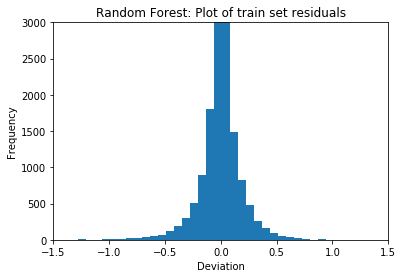

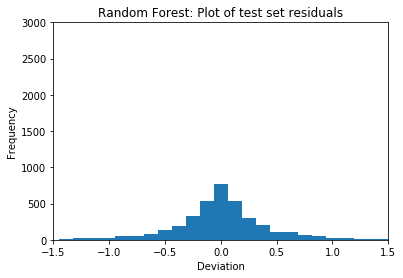

CPU times: user 19min 46s, sys: 3.88 s, total: 19min 49s
Wall time: 19min 58s


In [6]:
%%time
# random forest regression

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
    
param_grid_rf = {'n_estimators': np.arange(100, 150, 25),
                 'max_features': ['sqrt'],
                 'criterion': ['mae']} 

rf = RandomForestRegressor()
rf_random_grid = RandomizedSearchCV(estimator=rf, param_distributions=param_grid_rf, cv=3)
rf_random_grid.fit(X_train, y_train)

rf_train_predict = rf_random_grid.predict(X_train)
rf_test_predict = rf_random_grid.predict(X_test)

scoring(y_train, rf_train_predict, y_test, rf_test_predict, 'Random Forest')

# plotting residuals for training set
plt.hist(rf_train_predict - y_train, bins=50)
plt.title('Random Forest: Plot of train set residuals')
plt.xlabel('Deviation')
plt.ylabel('Frequency')
plt.xlim(-1.5, 1.5)
plt.ylim(0, 3000)
plt.show()

# plotting residuals for testing set
plt.hist(rf_test_predict - y_test, bins=50)
plt.title('Random Forest: Plot of test set residuals')
plt.xlabel('Deviation')
plt.ylabel('Frequency')
plt.xlim(-1.5, 1.5)
plt.ylim(0, 3000)
plt.show()

In [7]:
print('Random Forest Best Parameters:', rf_random_grid.best_params_)

Random Forest Best Parameters: {'n_estimators': 100, 'max_features': 'sqrt', 'criterion': 'mae'}


XGBoost model scores:

RMSE for train data: 0.022
RMSE for test data: 0.0437 

R2 Variance Score for train data:  0.9921
R2 Variance Score for test data:  0.9844 

MAE for train data:  0.1084
MAE for test data:  0.1451 

MAPE for train data:  26.0184 %
MAPE for test data:  29.7779 % 



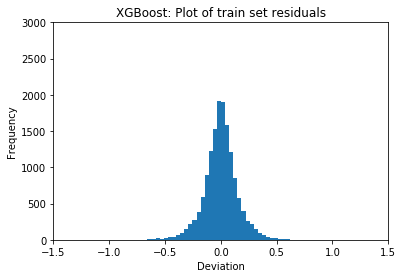

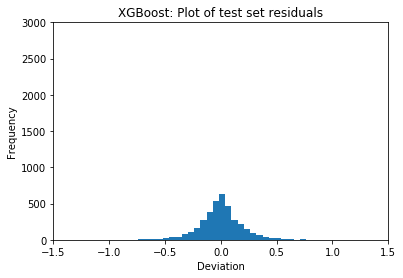

CPU times: user 4min 8s, sys: 2.66 s, total: 4min 11s
Wall time: 4min 19s


In [8]:
%%time
# XGBoost

import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error

param_grid_xgb = {'n_estimators': np.arange(100, 150, 25),
                 'max_depth': np.arange(5, 8, 1),
                 'min_child': np.arange(1, 5, 1),
                 'learning_rate': np.arange(.1, .3, .1),
                 'min_child_weight': np.arange(1, 3, 1)} 

xgb_reg = XGBRegressor(objective='reg:linear')
xgb_reg_grid = RandomizedSearchCV(xgb_reg, param_distributions=param_grid_xgb, cv=5)
xgb_reg_grid.fit(X_train, y_train)

xgb_train_predict = xgb_reg_grid.predict(X_train)
xgb_test_predict = xgb_reg_grid.predict(X_test)

scoring(y_train, xgb_train_predict, y_test, xgb_test_predict, 'XGBoost')

# plotting residuals for training set
plt.hist(xgb_train_predict - y_train, bins=50)
plt.title('XGBoost: Plot of train set residuals')
plt.xlabel('Deviation')
plt.ylabel('Frequency')
plt.xlim(-1.5, 1.5)
plt.ylim(0, 3000)
plt.show()

# plotting residuals for testing set
plt.hist(xgb_test_predict - y_test, bins=50)
plt.title('XGBoost: Plot of test set residuals')
plt.xlabel('Deviation')
plt.ylabel('Frequency')
plt.xlim(-1.5, 1.5)
plt.ylim(0, 3000)
plt.show()

In [9]:
print('XGBoost Best Parameters:', xgb_reg_grid.best_params_)

XGBoost Best Parameters: {'n_estimators': 125, 'min_child_weight': 2, 'min_child': 4, 'max_depth': 5, 'learning_rate': 0.1}


In [10]:
%%time
# feature importance using Random Forest

sel_rf = SelectFromModel(RandomForestRegressor(n_estimators = 100))
sel_rf.fit(X_train, y_train)

# what features are important
sel_rf.get_support()

# make a list and count of selected features
selected_feat_rf = X_train.columns[(sel_rf.get_support())]
len(selected_feat_rf)

# print names of selected features
print('Random Forest most important features:', selected_feat_rf)

Random Forest most important features: Index(['R', 'TB', 'DRC+', 'BRR', 'Def_DRAA', 'Def_FRAA'], dtype='object')
CPU times: user 31.9 s, sys: 295 ms, total: 32.2 s
Wall time: 33.5 s


In [11]:
%%time
# feature importance using XGBoost

sel_xgb = SelectFromModel(XGBRegressor(n_estimators = 100))
sel_xgb.fit(X_train, y_train)

# what features are important
sel_xgb.get_support()

# make a list and count of selected features
selected_feat_xgb = X_train.columns[(sel_xgb.get_support())]
len(selected_feat_xgb)

# print names of selected features
print('XGBoost most important features:', selected_feat_xgb)

XGBoost most important features: Index(['R', 'TB', 'DRC+', 'BRR', 'InnOuts', 'Def_A', 'Def_CS', 'Def_DRAA',
       'Def_FRAA', 'POS_1B'],
      dtype='object')
CPU times: user 2.52 s, sys: 27.9 ms, total: 2.55 s
Wall time: 2.58 s


In [12]:
%%time
# feature importance using Linear Regression

sel_lr = SelectFromModel(LinearRegression())
sel_lr.fit(X_train, y_train)

# what features are important
sel_lr.get_support()

# make a list and count of selected features
selected_feat_lr = X_train.columns[(sel_lr.get_support())]
len(selected_feat_lr)

# print names of selected features
print('Linear Regression most important features:', selected_feat_lr)

Linear Regression most important features: Index(['AVG', 'PA', 'AB', 'H', 'HR', 'TB', 'DRC+', 'BRR', 'Def_A', 'Def_DP',
       'Def_SB', 'Def_CS', 'Def_DRAA', 'Def_FRAA'],
      dtype='object')
CPU times: user 157 ms, sys: 11.4 ms, total: 168 ms
Wall time: 112 ms


In [13]:
# table of all model performance
model_results_dict = {'Linear Reg': [lin_reg_train_predict, lin_reg_test_predict], 'Random Forest': [rf_train_predict, rf_test_predict], 'XGBoost': [xgb_train_predict, xgb_test_predict]}

model_results_df = pd.DataFrame(index=model_results_dict.keys(), columns=['RMSE Train', 'RMSE Test', 'R2 Train', 'R2 Test', 'MAE Train', 'MAE Test', 'MAPE Train', 'MAPE Test'])

for key, value in model_results_dict.items():
  
    model_results_df.loc[key, 'RMSE Train'] = mean_squared_error(y_train, value[0]).round(4)
    model_results_df.loc[key, 'RMSE Test'] = mean_squared_error(y_test, value[1]).round(4)
    model_results_df.loc[key, 'R2 Train'] = r2_score(y_train, value[0]).round(4)
    model_results_df.loc[key, 'R2 Test'] = r2_score(y_test, value[1]).round(4)
    model_results_df.loc[key, 'MAE Train'] = mean_absolute_error(y_train, value[0]).round(4)
    model_results_df.loc[key, 'MAE Test'] = mean_absolute_error(y_test, value[1]).round(4)
    model_results_df.loc[key, 'MAPE Train'] = str(mean_absolute_percentage_error(y_train, value[0]).round(3)) + '%'
    model_results_df.loc[key, 'MAPE Test'] = str(mean_absolute_percentage_error(y_test, value[1]).round(3)) + '%'
    
print('Model Performance: \n')
print(model_results_df)


Model Performance: 

              RMSE Train RMSE Test R2 Train R2 Test MAE Train MAE Test  \
Linear Reg        0.0449    0.0454   0.9839  0.9838    0.1528   0.1569   
Random Forest     0.0346    0.2312   0.9876  0.9177    0.1208   0.3157   
XGBoost            0.022    0.0437   0.9921  0.9844    0.1084   0.1451   

              MAPE Train MAPE Test  
Linear Reg       38.719%   39.258%  
Random Forest    23.648%   53.725%  
XGBoost          26.018%   29.778%  
